# Chapter 2 -- Traditional estimation and hypothesis tests: anesthetic effects on mice

This notebook presents the Python equivalent for the R code example from **Box 2.2** featured in the book.

## Worked example of traditional inference for two-group design

Low et al (2016) examined the effects of two different anesthetics on aspects of the physiology of the mouse. Twelve mice were anesthetized with isoflurane and eleven mice were anesthetized with alpha chloralose and blood CO~2~ levels were recorded after 120 minutes. The *H*~0~ was that there is no difference between the anesthetics in the mean blood CO~2~ level. This is an independent comparison because individual mice were only given one of the two anesthetics.

### Preliminaries

First, load the required packages, i.e., Pandas and NumPy

In [22]:
import pandas as pd
import numpy as np

Import low data file

In [2]:
data = pd.read_csv("./data/lowco2.csv")
data.head()

,anesth,co2
0,iso,43
1,iso,35
2,iso,50
3,iso,39
4,iso,56


We can generate a quick visualization.

<Axes: xlabel='co2', ylabel='anesth'>

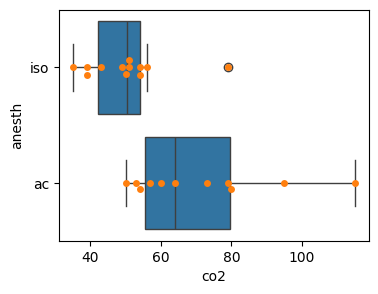

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(4,3))
sns.boxplot(data=data, x='co2', y='anesth')
sns.swarmplot(data=data, x='co2', y='anesth')

### Get summary statistics by anesthetic

In [4]:
data.groupby('anesth').describe()

co2                                                     
       count       mean        std   min   25%   50%   75%    max
anesth                                                           
ac      11.0  70.909091  20.201260  50.0  55.5  64.0  79.5  115.0
iso     12.0  50.000000  11.393778  35.0  42.0  50.5  54.0   79.0

In [5]:
(
    data
    .groupby('anesth')
    .agg(['count', 'mean', 'median', 'std', 'var', 'sem'])
    .round(1)
)

co2                               
       count  mean median   std    var  sem
anesth                                     
ac        11  70.9   64.0  20.2  408.1  6.1
iso       12  50.0   50.5  11.4  129.8  3.3

The `summarySE` function in R calculates the confidence interval using the **t-distribution**.

For calculating the confidences intervals of the means, we need to import StatsModels, and define functions to extract the boundaries of the confidence interval.

In [6]:
from statsmodels.stats.weightstats import DescrStatsW

In [7]:
# Define confidence interval functions
ci_lower = lambda x: DescrStatsW(x).tconfint_mean()[0]
ci_upper = lambda x: DescrStatsW(x).tconfint_mean()[1]

In [8]:
data.groupby('anesth').agg(
    ci_lower = ('co2', ci_lower),
    ci_upper = ('co2', ci_upper)
).round(1)

,ci_lower,ci_upper
anesth,,
ac,57.3,84.5
iso,42.8,57.2


Or we can define a custom function, for example, to integrate any distribution for calculating the confidence interval of the mean.

In [43]:
from scipy.stats import t as t_dist  # Avoid mixing t value with t-distribution

def se(x):
    # Returns the standard error of the data
    return np.sqrt(x.var() / len(x))

def ci95(x: np.array) -> tuple:
    # Returns the 95% confidence interval of the mean (t-distribution)
    mean_x = x.mean()  # Mean of the data
    sem = se(x)  # Standard error of the log-transformed data
    t = t_dist.ppf(.975, df=len(x)-1)  # Critical t-value with q=1-α/2
    
    # Calculate the confidence interval
    return (mean_x - t*sem, mean_x + t*sem)

In [ ]:
# Create two separate functions for lower and upper bounds
ci95_lower = lambda x: ci95(x)[0]
ci95_upper = lambda x: ci95(x)[1]

# Use named aggregation to create separate columns
summary_df = (
    data.groupby('anesth')['co2']
    .agg(
        n='count',
        Mean='mean',
        SD='std',
        Variance='var',
        SE=se,
        ci95_lower=ci95_lower,
        ci95_upper=ci95_upper
    )
    .round(2)
)

In [52]:
data.groupby('anesth').agg(['count', 'mean', 'median', 'std', se, ci95])

print(summary_df)

         n   Mean     SD  Variance    SE  ci95_lower  ci95_upper
anesth                                                          
ac      11  70.91  20.20    408.09  6.09       57.34       84.48
iso     12  50.00  11.39    129.82  3.29       42.76       57.24


### t-test for evaluating differences between two group means

Fitting a simple linear model with anaesthetic as a categorical predictor provides additional information including an ANOVA table and allows effect sizes to be calculated

In [9]:
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm

model = smf.ols("co2 ~ anesth", data=data)
results = model.fit()

anova_lm(results)

,df,sum_sq,mean_sq,F,PR(>F)
anesth,1.0,2509.090909,2509.090909,9.564672,0.005515
Residual,21.0,5508.909091,262.329004,NaN,NaN


In [10]:
import pingouin as pg

ix = data['anesth'] == 'ac'

pg.compute_effsize(data.loc[ix, 'co2'], data.loc[~ix, 'co2'], eftype='cohen')

1.2909576499753916

Note that we've chosen to show a standardized effect size, using the pooled variance from the analysis of variance - Residual MS = 262.33, and $\sqrt{262.33} = 16.2$.

In [11]:
262.33**.5

16.19660458244258

### Homoscedasticity

While we prefer graphical methods for assessing assumptions, we can evaluate differences between group variances with Levene's test.

In [12]:
pg.homoscedasticity(
    data=data,
    dv='co2',
    group='anesth',
    method='levene'
)

,W,pval,equal_var
levene,2.604035,0.121519,True


### Comparing group means with a t-test assuming equal variances

In [13]:
ach = data.loc[ix, 'co2']
iso = data.loc[~ix, 'co2']

pg.ttest(x=ach, y=iso, correction=False)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,3.09268,21,two-sided,0.005515,"[6.85, 34.97]",1.290958,8.039,0.838576


### Comparing group means with a t-test allowing different group variances

In [14]:
pg.ttest(data.loc[ix, 'co2'], data.loc[~ix, 'co2'], correction=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,3.020569,15.485313,two-sided,0.008362,"[6.19, 35.62]",1.290958,7.098,0.838576


### Non-parametric test

The non-parametric Wilcoxon-Mann-Whitney test assesses whether the two samples come from identical populations that don't have to be normally distributed.

In [21]:
pg.mwu(
    ach, iso, method='asymptotic',
    use_continuity=True  # With continuity correction
)

,U-val,alternative,p-val,RBC,CLES
MWU,114.0,two-sided,0.003398,0.727273,0.863636


Note that `U-val` returned by Pingouin (or SciPy) is the U-value for `x`, i.e., the `ach` group. If we reverse `x` and `y`, we obtain the U-value of the `iso` group.

In [ ]:
from scipy.stats import rankdata

ach = data.loc[ix, 'co2']
iso = data.loc[~ix, 'co2']

# Combine the data for ranking
combined_data = np.concatenate((ach, iso))

# Rank the combined data using the average method (default) for ties
ranks = rankdata(combined_data, method='average')

# Separate the ranks back into the original groups
ach_ranks = ranks[:len(ach)]
iso_ranks = ranks[len(ach):]

# Calculate the sum of ranks for each group
R_ach = np.sum(ach_ranks)
R_iso= np.sum(iso_ranks)

# Number of data points in each group
n_ach = len(ach)
n_iso = len(iso)

# Calculate the U-statistic for each group
U_ach = n_ach * n_iso + (n_ach * (n_ach + 1)) / 2 - R_ach
U_iso = n_ach * n_iso + (n_iso * (n_iso + 1)) / 2 - R_iso

# The Mann-Whitney U-statistic is the minimum of U_ach and U_iso
U_statistic = min(U_ach, U_iso)

In [17]:
print("Mann-Whitney U test - Manual calculation\n")
print("1. Combined and ranked data:")
print(" Combined data:", combined_data)
print(" Corresponding ranks:", ranks)
print()
print("2. Rank sums:")
print(" Sum of ranks for 'ach' group =", R_ach)
print(" Sum of ranks for 'iso' group =", R_iso)
print()
print("3. U-statistics calculation:")
print(" Number of observations in 'ach' group =", n_ach)
print(" Number of observations in 'iso' group =", n_iso)

Mann-Whitney U test - Manual calculation

1. Combined and ranked data:
 Combined data: [ 60  53  54  73  64  95  57  80 115  79  50  43  35  50  39  56  54  39
  51  49  54  51  79]
 Corresponding ranks: [16.  10.  12.  18.  17.  22.  15.  21.  23.  19.5  6.5  4.   1.   6.5
  2.5 14.  12.   2.5  8.5  5.  12.   8.5 19.5]

2. Rank sums:
 Sum of ranks for 'ach' group = 180.0
 Sum of ranks for 'iso' group = 96.0

3. U-statistics calculation:
 Number of observations in 'ach' group = 11
 Number of observations in 'iso' group = 12


In [18]:
# Critical U value (two-tailed) from table, for n1=11, n2=12, alpha=0.05
# https://real-statistics.com/statistics-tables/mann-whitney-table/
U_critical = 33

print(" U-statistic for 'ach' group (U_ach) =", U_ach)
print(" U-statistic for 'iso' group (U_iso) = ", U_iso)
print(f" Mann-Whitney U-statistic (min(U_ach, U_iso)) = {U_statistic}")
print()
print("4. Comparison with critical value:")
print(f" Critical U value (n={n_iso}, m={n_ach}, \
alpha=0.05, two-tailed): {U_critical}\n")

# Compare U to the critical value and draw a conclusion
if U_statistic <= U_critical:
    print("Conclusion: reject the null hypothesis.")
    print(" There is a statistically significant difference \
    between the 'ach' and 'iso' groups.")
else:
    print("Conclusion: fail to reject the null hypothesis.")
    print(" There is no statistically significant difference \
    between the 'ach' and 'iso' groups.")

 U-statistic for 'ach' group (U_ach) = 18.0
 U-statistic for 'iso' group (U_iso) =  114.0
 Mann-Whitney U-statistic (min(U_ach, U_iso)) = 18.0

4. Comparison with critical value:
 Critical U value (n=12, m=11, alpha=0.05, two-tailed): 33

Conclusion: reject the null hypothesis.
 There is a statistically significant difference     between the 'ach' and 'iso' groups.
